# RNN example for sine wave

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
%matplotlib inline
%config Completer.use_jedi = False

## Create Data
Let's use numpy to create a simple sine wave

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)

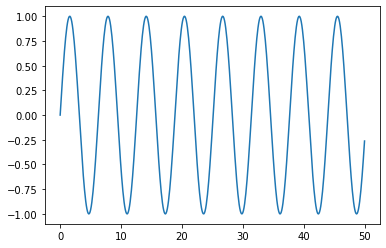

In [3]:
plt.plot(x,y)

Let's turn this into a dataframe

In [4]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [5]:
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


## Train test split

In [6]:
test_perc = 0.1
test_points = round(len(df)*test_perc)
test_index = len(df)-test_points

In [7]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

## Scale

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
length = 2
batch_size=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [14]:
# What does the first batch look like?
X, y = generator[0]
print('For the given array', X.flatten())
print('Predict ', y)

For the given array [0.49999912 0.54991622]
Predict  [[0.59933458]]


In [15]:
# let's redefine the generator for 50 steps and then predict the next step
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [16]:
# What does the first batch look like?
X, y = generator[0]
print('For the given array', X.flatten())
print('Predict ', y)

For the given array [4.99999116e-01 5.49916225e-01 5.99334579e-01 6.47760405e-01
 6.94709850e-01 7.39713809e-01 7.82322618e-01 8.22110545e-01
 8.58680040e-01 8.91665714e-01 9.20737985e-01 9.45606372e-01
 9.66022399e-01 9.81782075e-01 9.92727935e-01 9.98750612e-01
 9.99789928e-01 9.95835500e-01 9.86926839e-01 9.73152957e-01
 9.54651478e-01 9.31607263e-01 9.04250562e-01 8.72854714e-01
 8.37733417e-01 7.99237589e-01 7.57751870e-01 7.13690771e-01
 6.67494535e-01 6.19624741e-01 5.70559686e-01 5.20789614e-01
 4.70811810e-01 4.21125636e-01 3.72227539e-01 3.24606094e-01
 2.78737119e-01 2.35078919e-01 1.94067715e-01 1.56113277e-01
 1.21594831e-01 9.08572769e-02 6.42077324e-02 4.19124713e-02
 2.41942605e-02 1.12301346e-02 3.14962674e-03 3.34747619e-05
 1.91281421e-03 8.76886734e-03]
Predict  [[0.02053313]]


## Create Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten

In [18]:
# We are only using 1 feature in our time series
n_features = 1

In [19]:
model = Sequential()

# LSTM layer
model.add(LSTM(50, input_shape=(length, n_features)))

# Final prediction
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(generator, epochs=5)

Epoch 1/5
401/401 [==============================] - 10s 13ms/step - loss: 0.0137
Epoch 2/5
401/401 [==============================] - 5s 13ms/step - loss: 1.4814e-04
Epoch 3/5
401/401 [==============================] - 5s 13ms/step - loss: 1.1657e-04
Epoch 4/5
401/401 [==============================] - 6s 15ms/step - loss: 2.8861e-04
Epoch 5/5
401/401 [==============================] - 6s 16ms/step - loss: 8.1475e-05


<AxesSubplot:>

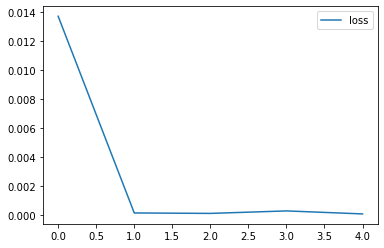

In [22]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on test data

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


## Inverse transformation and compare

In [24]:
# IGNORE Warning, pandas is telling something we already know
true_prediction = scaler.inverse_transform(test_predictions)
test['prediction'] = true_prediction

C:\Users\junai\AppData\Local\Temp\ipykernel_13000\1478308189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = true_prediction


<AxesSubplot:>

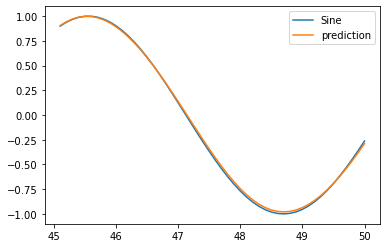

In [25]:
test.plot()

## Forecasting

In [29]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [30]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [35]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=5)

Epoch 1/5
451/451 [==============================] - 9s 13ms/step - loss: 0.0149
Epoch 2/5
451/451 [==============================] - 6s 13ms/step - loss: 1.6225e-04
Epoch 3/5
451/451 [==============================] - 6s 13ms/step - loss: 2.2950e-04
Epoch 4/5
451/451 [==============================] - 6s 13ms/step - loss: 9.6454e-05
Epoch 5/5
451/451 [==============================] - 6s 13ms/step - loss: 9.6398e-05


In [36]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


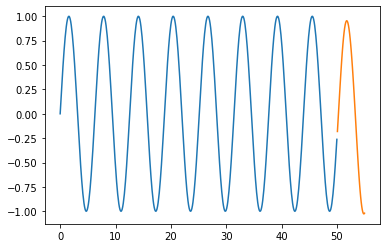

In [37]:
forecast = scaler.inverse_transform(forecast)
forecast_index = np.arange(50.1,55.1,step=0.1)
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)